### Audio Fingerprinting fitness tests

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import maximum_filter
import math
import numpy as np
import matplotlib.pyplot as plt
from librosa import load as load_audio, stft, amplitude_to_db
from librosa.display import specshow
from statistics import NormalDist
from scipy.ndimage import label as label_features
from scipy.ndimage import maximum_position as extract_region_maximums
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from copy import deepcopy 

In [2]:
def plot_spectrogram(file_path):
    # Load the MP3 file using librosa
    y, sr = librosa.load(file_path, sr=None)
    
    # Print audio information
    print(f"Audio File: {file_path}")
    print(f"Sample Rate (Hz): {sr}")
    print(f"Audio Length (seconds): {len(y) / sr:.2f}")

    # Compute the Short-Time Fourier Transform (STFT)  
    N_FFT = 2048  # FFT window size
    N_O = N_FFT // 4
    D = librosa.stft(y, n_fft=N_FFT)
    print(f"D shape: {D.shape}")
    
    frame_rate = sr / N_O
    print(f"Frame Rate (Hz): {frame_rate:.2f}")
  
    # Convert the complex-valued STFT result to magnitude
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='inferno')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

In [ ]:
plot_spectrogram('audios/scala.mp3')

In [2]:
def constellation_map_builder(file_path): 
    #step 1: Set parameters
    N_FFT = 2048  # FFT window size
    N_O = N_FFT // 4

    #step 2: Load audio file
    y, sr = librosa.load(file_path, sr=None)

    #step 3: Compute the spectrogram
    D = librosa.stft(y, n_fft=N_FFT, hop_length=N_O)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    #step 4: Define window lengths for peak detection  
    d_t = 15
    d_f = 15

    #step 5: Select settings for peak detection
    #using maximum filter to detect local maxima
    local_max = maximum_filter(S_db, size=(d_t, d_f))

    #step 6: Create an identification matrix
    peaks = (S_db == local_max)  # Peaks are where the original value is equal to the local max

    #step 6.5: Apply an amplitude threshold to filter out insignificant peaks
    amplitude_threshold = -20  # dB, adjust as needed
    peaks &= (S_db > amplitude_threshold)

    #step 7: Extract peaks (time, frequency, amplitude)
    times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=N_O)
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=N_FFT)

    peak_indices = np.where(peaks)
    peak_times = times[peak_indices[1]]
    peak_freqs = frequencies[peak_indices[0]]
    peak_ampls = S_db[peak_indices]

    #normalize amplitudes for color mapping
    norm_ampls = (peak_ampls - np.min(peak_ampls)) / (np.max(peak_ampls) - np.min(peak_ampls))

    #save the peaks to a file (optional)
    peak_data = np.vstack((peak_times, peak_freqs, peak_ampls)).T
    peak_data_filtered = np.array([[round(x, 1), round(y, 1)] for x, y, _ in peak_data])
    np.savetxt('peaks.csv', peak_data_filtered, delimiter=',', header='Time,Frequency', comments='')

    ##plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 7), sharex=True)

    #plot the spectrogram with peaks

    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='inferno', ax=ax[0])
    sc = ax[1].scatter(peak_times, peak_freqs, c=norm_ampls, cmap='inferno', marker='x')
    ax[0].set_title('Spectrogram')
    ax[1].set_title('Constellation Map')
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Hz')
    ax[1].set_ylabel('Hz')
    fig.colorbar(sc, ax=ax[1], format="%1.1f dB", norm=norm_ampls)

    plt.show()
    
    return peak_data_filtered

In [3]:
def peak_detection(file_path, threshold):
    y, _ = load_audio(path=file_path, sr=None)

    #do transformations
    x = stft(y)
    x = amplitude_to_db(abs(x))
    
    #remove zero values
    flattened = np.matrix.flatten(x)
    filtered = flattened[flattened > np.min(flattened)]

    #create a normal distribution from frequency intensities
    #then map a zscore onto each intensity value
    ndist = NormalDist(np.mean(filtered), np.std(filtered))
    zscore = np.vectorize(lambda x: ndist.zscore(x))
    zscore_matrix = zscore(x)

    #create label matrix from frequency intensities that are
    #above threshold
    mask_matrix = zscore_matrix > threshold
    labelled_matrix, num_regions = label_features(mask_matrix)
    label_indices = np.arange(num_regions) + 1

    #for each isolated region in the mask, identify the maximum
    #value, then extract it position
    peak_positions = extract_region_maximums(zscore_matrix, labelled_matrix, label_indices)

    #finally, create list of peaks (time, frequency, intensity)
    peaks = [(x, y) for y, x in peak_positions]
    return peaks

In [ ]:
peaks = constellation_map_builder('audios/scala.mp3')

In [5]:
def create_database(hashes):
    database = defaultdict(list)
    for hash_value, time_offset in hashes:
        #if hash_value in database:
            #print(f"hashvalue {hash_value} alraedy inside")
        database[hash_value].append(time_offset)
        #print(f"{database[hash_value]} values")
    return database

In [6]:
def generate_hashes(constellation_map, fan_out=10):
    hashes = []
    for anchor in constellation_map:
        for target in constellation_map:
            if target[0] > anchor[0]:  #ensure target is after anchor in time
                delta_t = target[0] - anchor[0]
                freq1, freq2 = anchor[1], target[1]
                hash_value = (freq1, freq2, delta_t)
                hashes.append((hash_value, anchor[0]))  # (hash_value, time_offset)
                
                #limit the fan-out to a certain number of target points
                if len(hashes) >= fan_out:
                    break
    return hashes

Testing

In [12]:
peaks1 = peak_detection('audios/scala.mp3', 1)

a = generate_hashes(peaks1, 10)
print(a)

c = create_database(a)

print(c[(33, 36, 21)].pop())


[((13, 4, 94), 30), ((13, 4, 119), 30), ((13, 4, 143), 30), ((13, 5, 170), 30), ((13, 16, 309), 30), ((13, 21, 83), 30), ((13, 24, 154), 30), ((13, 30, 109), 30), ((13, 30, 306), 30), ((13, 31, 85), 30), ((4, 4, 25), 124), ((4, 4, 24), 149), ((4, 5, 27), 173), ((5, 16, 139), 200), ((16, 307, 11), 339), ((21, 4, 11), 113), ((24, 5, 16), 184), ((30, 4, 10), 139), ((30, 16, 3), 336), ((31, 4, 9), 115), ((32, 4, 22), 127), ((33, 4, 65), 59), ((33, 4, 9), 140), ((33, 4, 4), 145), ((33, 4, 22), 151), ((34, 4, 13), 136), ((34, 5, 9), 191), ((35, 4, 8), 165), ((35, 4, 4), 169), ((35, 5, 24), 176), ((36, 4, 87), 37), ((36, 4, 12), 161), ((36, 4, 7), 166), ((37, 5, 9), 191), ((38, 16, 138), 201), ((37, 16, 128), 211), ((43, 4, 13), 111), ((46, 4, 13), 136), ((47, 16, 121), 218), ((50, 4, 13), 160), ((51, 5, 12), 188), ((52, 4, 9), 115), ((53, 13, 19), 11), ((53, 16, 129), 210), ((54, 13, 24), 6), ((54, 13, 20), 10), ((55, 4, 10), 139), ((56, 4, 12), 137), ((56, 16, 103), 236), ((58, 4, 7), 117),

In [7]:
def find_closest_key(target_key, dictionary):
    keys_array = np.array(list(dictionary.keys()))
    distances = np.linalg.norm(keys_array - target_key, axis=1)
    closest_index = np.argmin(distances)
    closest_key = tuple(keys_array[closest_index])
    closest_distance = distances[closest_index] 
    return closest_key, closest_distance

In [16]:
def search_database(database, sample_hashes, max_key_distance):
    match_offsets = []
    for hash_value, sample_offset in sample_hashes:
        closest_key, closest_distance =  find_closest_key(hash_value, database)
        print(f"closest key: {closest_key}, closest_distance: {closest_distance}")
        if closest_distance < max_key_distance:
            for track_offset in database[closest_key]:
                match_offsets.append((track_offset, sample_offset))
                database[closest_key] = database[closest_key][1:]
                break
    return match_offsets

In [9]:
def angle_equivalent(d, d_max=15):
    return (180 / np.pi) * np.arctan(d / d_max)

In [10]:
import math

def fitness_calculation_angle_correction(m1, q1, m2, q2, intersection_too_far):
    if m1 == m2 or intersection_too_far:
        if q1 == q2:
            return 0.0
        else:
            return angle_equivalent(abs(q2 - q1) / math.sqrt(1 + m1**2)) #distance of the 2 parallel lines
    else: #lines intersect
        if m1 * m2 == -1:
            return 90.0
        else:
            tan_theta = abs((m1 - m2) / (1 + m1 * m2))
            theta_radians = math.atan(tan_theta)
            theta_degrees = math.degrees(theta_radians)
            return theta_degrees
        
def fitness_calculation(m1, q1, m2, q2, intersection_too_far):
    if m1 == m2 or intersection_too_far:
        if q1 == q2:
            return 0.0
        else:
            return abs(q2 - q1) / math.sqrt(1 + m1**2) #distance of the 2 parallel lines
    else: #lines intersect
        if m1 * m2 == -1:
            return 90.0
        else:
            tan_theta = abs((m1 - m2) / (1 + m1 * m2))
            theta_radians = math.atan(tan_theta)
            theta_degrees = math.degrees(theta_radians)
            return theta_degrees

10.606601717798211


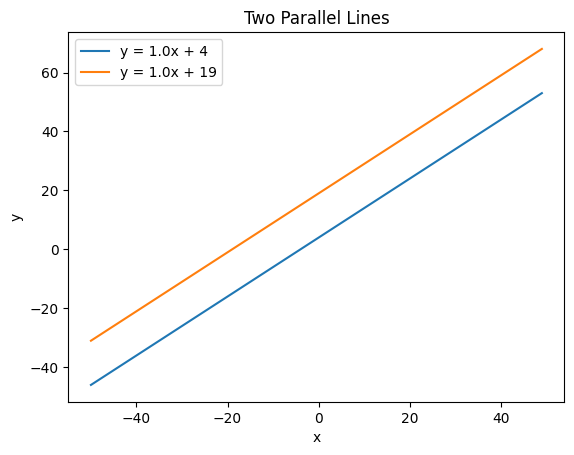

In [12]:
import matplotlib.pyplot as plt

# Example usage:
m1, q1 = 1.0, 4  
m2, q2 = 1.0, 19

intersection = fitness_calculation(m1, q1, m2, q2, False)

print(intersection)

# Generate x values for the lines
x = range(-50, 50)

# Calculate y values for the lines using the equations y = mx + q
y1 = [m1 * x_val + q1 for x_val in x]
y2 = [m2 * x_val + q2 for x_val in x]

# Plot the lines
plt.plot(x, y1, label=f"y = {m1}x + {q1}")
plt.plot(x, y2, label=f"y = {m2}x + {q2}")

# Set the plot title and labels
plt.title("Two Parallel Lines")
plt.xlabel("x")
plt.ylabel("y")

# Add a legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()

#### Testing single audio

In [11]:
def linear_func(x, a, b):
    return a * x + b

hashes0:  [((8, 0, 23), 4), ((8, 0, 51), 4), ((8, 0, 58), 4), ((8, 0, 113), 4), ((8, 0, 127), 4), ((8, 0, 131), 4), ((8, 0, 135), 4), ((8, 0, 150), 4), ((8, 0, 162), 4), ((8, 0, 181), 4), ((8, 0, 193), 4), ((8, 0, 211), 4), ((8, 0, 221), 4), ((8, 0, 233), 4), ((8, 0, 290), 4), ((8, 0, 308), 4), ((8, 0, 390), 4), ((8, 0, 406), 4), ((8, 0, 425), 4), ((8, 0, 439), 4), ((0, 0, 28), 27), ((0, 0, 7), 55), ((0, 0, 55), 62), ((0, 0, 14), 117), ((0, 0, 4), 131), ((0, 0, 4), 135), ((0, 0, 15), 139), ((0, 0, 12), 154), ((0, 0, 19), 166), ((0, 0, 12), 185), ((0, 0, 18), 197), ((0, 0, 10), 215), ((0, 0, 12), 225), ((0, 0, 57), 237), ((0, 0, 18), 294), ((0, 0, 82), 312), ((0, 0, 16), 394), ((0, 0, 19), 410), ((0, 0, 14), 429), ((0, 0, 21), 443), ((0, 0, 34), 464), ((0, 0, 6), 498), ((0, 0, 8), 504), ((5, 0, 17), 38), ((5, 0, 12), 43), ((8, 0, 10), 384), ((8, 0, 2), 392), ((8, 0, 12), 398), ((8, 0, 9), 401), ((8, 0, 1), 409), ((8, 0, 4), 425), ((21, 0, 8), 19), ((22, 0, 6), 21), ((22, 0, 28), 27), ((

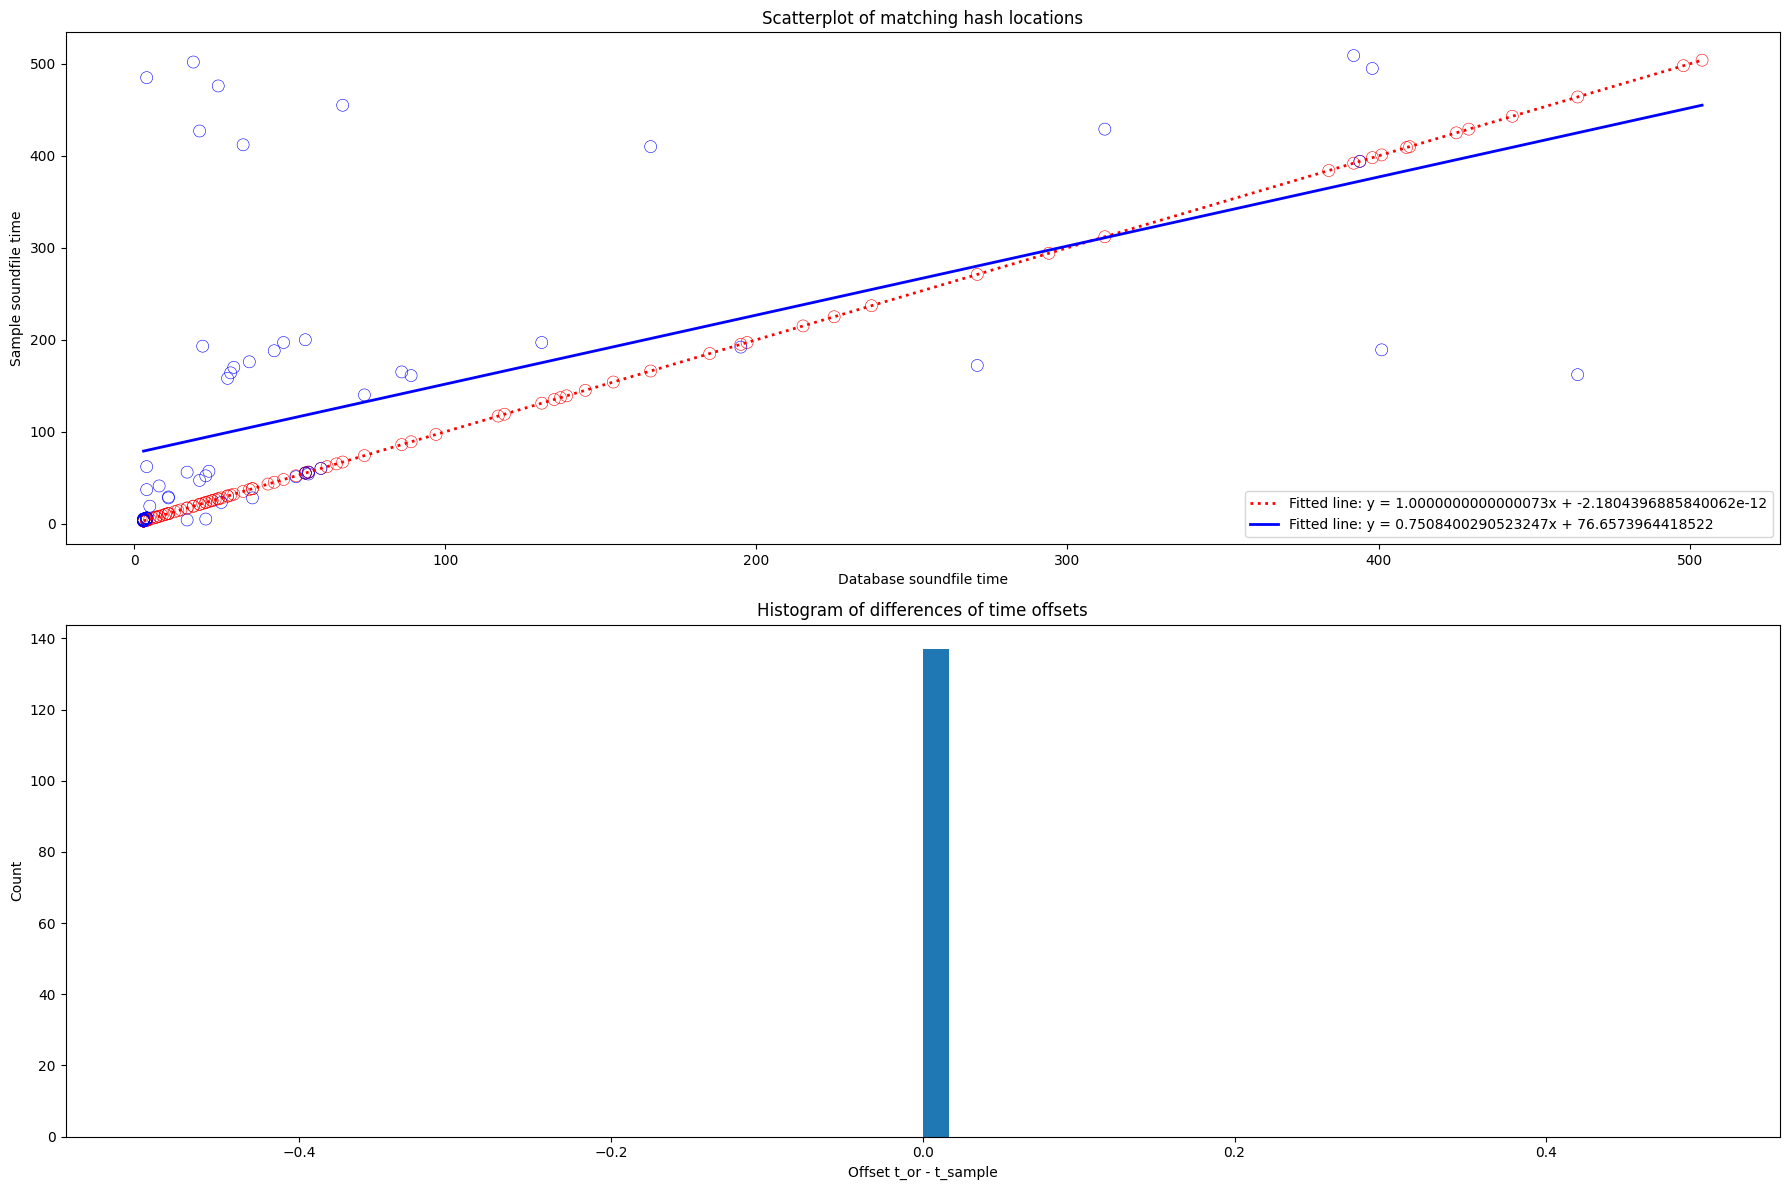

In [18]:
import random
from numpy import dot
from numpy.linalg import norm

threshold = 2 #1.5
fan_out = 20  #20

peaks_original = peak_detection('./audios/G4_guitar.mp3', threshold)
hashes0 = generate_hashes(peaks_original, fan_out)
print("hashes0: ", hashes0)
hash_table = create_database(hashes0)
print("database: ", hash_table)

peaks_copy_original = peak_detection('./audios/G4_guitar.mp3', threshold)
hashes1 = generate_hashes(peaks_copy_original, fan_out)
print("hashes1: ", hashes1)
print(len(hashes1))

peaks_test = peak_detection('./audios/G4_guitar_Chorus_low.mp3', threshold)
hashes2 = generate_hashes(peaks_test, fan_out)
print("hashes2: ", hashes2)
print(len(hashes2))

copy_hash_table = deepcopy(hash_table)
time_pairs1 = search_database(copy_hash_table, hashes1, 15)
print("time_pairs1: ", time_pairs1)
or_times1, sample_times1 = zip(*time_pairs1)
x_vals_full = np.linspace(min(or_times1), max(or_times1))

popt1, pcov1 = curve_fit(linear_func, or_times1, sample_times1)
a_opt1, b_opt1 = popt1

x_vals1 = np.array(or_times1)
y_vals1 = linear_func(x_vals_full, a_opt1, b_opt1)

print("or_times1: ",or_times1)
max_x = max(or_times1)
print(max_x)

copy_hash_table = deepcopy(hash_table)
time_pairs2 = search_database(copy_hash_table, hashes2, 15)
print("time_pairs2: ", time_pairs2)
or_times2, sample_times2 = zip(*time_pairs2)

popt2, pcov2 = curve_fit(linear_func, or_times2, sample_times2)
a_opt2, b_opt2 = popt2

x_vals2 = np.array(or_times1)
y_vals2 = linear_func(x_vals_full, a_opt2, b_opt2)

x_intersection =  (b_opt2 - b_opt1)/(a_opt1 - a_opt2)

plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
print(len(or_times1))
print(len(or_times2))
print(f'Confidence: {(len(or_times2) / len(or_times1))}')
print(abs(a_opt1 - a_opt2))
dissimilarity = fitness_calculation(a_opt1, b_opt1, a_opt2, b_opt2, x_intersection >= max_x * 1.5 or x_intersection <= -max_x * 0.2)
print("initial dissimilarity: ", dissimilarity)
print("inverse confidence: ", (len(or_times1) / len(or_times2)))
print('final dissimililarity: ', dissimilarity * (len(or_times1) / len(or_times2)))
plt.scatter(or_times1, sample_times1, facecolors='none', edgecolors='red', linewidths=0.4, s=75)
plt.plot(x_vals_full, y_vals1, color='red', linewidth=2, label=f'Fitted line: y = {a_opt1}x + {b_opt1}', linestyle='dotted')
plt.scatter(or_times2, sample_times2, facecolors='none', edgecolors='blue', linewidths=0.4, s=75)
plt.plot(x_vals_full, y_vals2, color='blue', linewidth=2, label=f'Fitted line: y = {a_opt2}x + {b_opt2}', linestyle='solid')
plt.xlabel('Database soundfile time')
plt.ylabel('Sample soundfile time')
plt.title('Scatterplot of matching hash locations')
plt.legend()

# Create histogram of time differences
delta_ts = [or_t - sample_t for or_t, sample_t in time_pairs1]

plt.subplot(2, 1, 2)
plt.hist(delta_ts, bins=60)
plt.xlabel('Offset t_or - t_sample')
plt.ylabel('Count')
plt.title('Histogram of differences of time offsets')

plt.tight_layout()
plt.show()


Reverb applied, intensity: low
Intersection point: 65.65116561969259
Dissimilarity start: 19.22800599581213
Len or_times1: 137, len or_times: 91
Confidence: 0.6642335766423357
Inverse of confidence: 1.5054945054945055
Dissimilarity: 28.947657378310566
Reverb applied, intensity: medium
Intersection point: 73.25236517546236
Dissimilarity start: 21.650267662187858
Len or_times1: 137, len or_times: 95
Confidence: 0.6934306569343066
Inverse of confidence: 1.4421052631578948
Dissimilarity: 31.22196494441828
Reverb applied, intensity: high
Intersection point: 75.17060440369123
Dissimilarity start: 17.827030909897346
Len or_times1: 137, len or_times: 99
Confidence: 0.7226277372262774
Inverse of confidence: 1.3838383838383839
Dissimilarity: 24.669729642989257
Chorus applied, intensity: low
Intersection point: 305.58838486221777
Dissimilarity start: 7.911332956859845
Len or_times1: 137, len or_times: 80
Confidence: 0.583941605839416
Inverse of confidence: 1.7125
Dissimilarity: 13.548157688622485

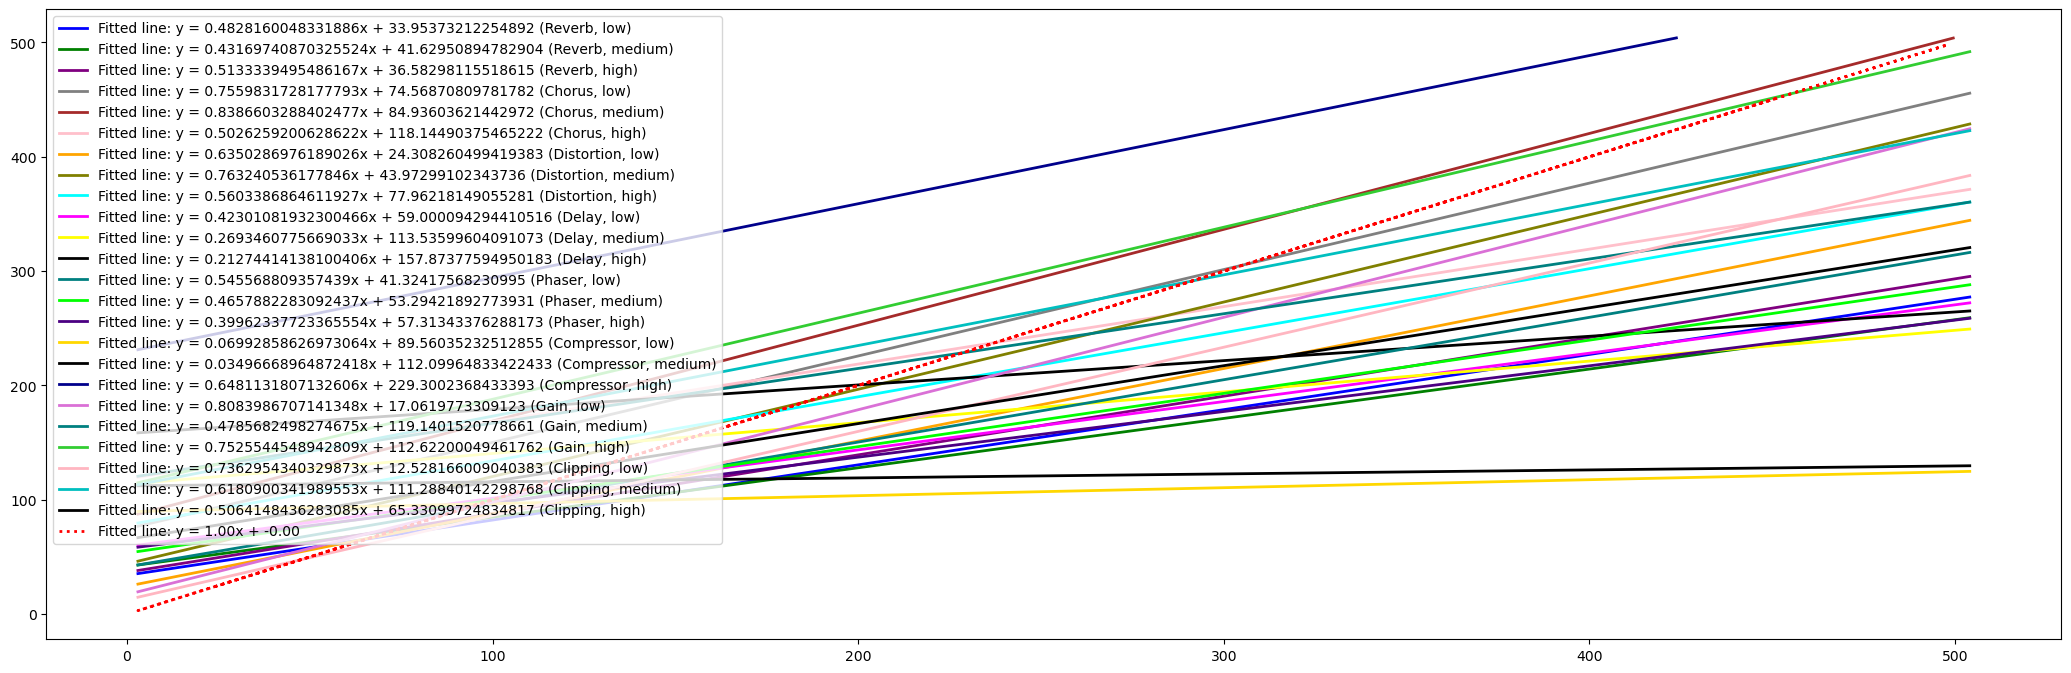

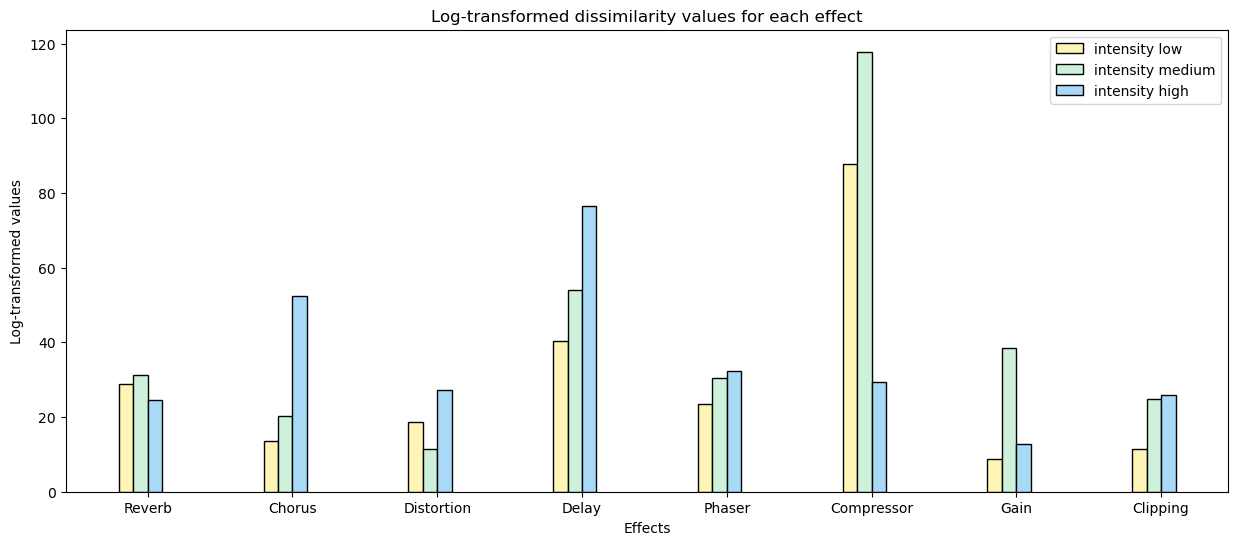

In [152]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

plt.figure(figsize=(26, 18))

plt.subplot(2, 1, 1)

file_path = 'audios/G4_guitar'
threshold = 2
fan_out = 20

peaks_original = peak_detection(file_path + ".mp3", threshold)
hashes0 = generate_hashes(peaks_original, fan_out)
#hashes0 = generate_hashes(peaks0, 4, 1000, 0.5)

# Store hashes for the original track
hash_table = create_database(hashes0)

peaks_copy_original = peak_detection(file_path + ".mp3", threshold)
hashes1 = generate_hashes(peaks_copy_original, fan_out)

copy_hash_table = deepcopy(hash_table)
time_pairs1 = search_database(copy_hash_table, hashes1)
or_times1, sample_times1 = zip(*time_pairs1)

popt1, pcov1 = curve_fit(linear_func, or_times1, sample_times1)
a_opt1, b_opt1 = popt1

min_x = min(or_times1)
max_x = max(or_times1)

all_hashes = []

#
effects = ['Reverb', 'Chorus', "Distortion", 'Delay', 'Phaser', 'Compressor', 'Gain', "Clipping"]
#effects = ["Reverb"]
intensities = ["low", "medium", "high"]
#intensities = ["level_1", "level_2", "level_3", "level_4", "level_5", "level_6", "level_7", "level_8", "level_9", "level_10"]
colors = ['blue', 'green', 'purple', 'gray', 'brown', 'pink', 'orange', 'olive', 'cyan', 'magenta', 'yellow', 'black', 'teal', 'lime', 'indigo', 'gold', 'black', 'darkblue', 'orchid', 'teal', 'limegreen', 'lightpink', 'c', 'black', 'acqua', 'steelblue', 'plum']
j = 0

dissimilarities = {effect: [] for effect in effects}

for effect in effects:
    for intensity in intensities: 
        file_tested = file_path + "_" + str(effect) + "_" + str(intensity) + ".mp3"
        peaks_temp = peak_detection(file_tested, threshold)
        hashes_temp = generate_hashes(peaks_temp, fan_out)
        copy_hash_table = deepcopy(hash_table)
        time_pairs_temp = search_database(copy_hash_table, hashes_temp)
        if len(time_pairs_temp) >= 2:
            or_times, sample_times = zip(*time_pairs_temp)
            popt, pcov = curve_fit(linear_func, or_times, sample_times)
            a_opt, b_opt = popt
            x_intersection =  (b_opt - b_opt1)/(a_opt1 - a_opt)

            #x_vals = np.array(or_times)
            x_vals = np.linspace(min_x, max_x, 1000)  # 1000 points for smoothness
            y_vals = linear_func(x_vals, a_opt, b_opt)
            mask = (y_vals >= min_x) & (y_vals <= max_x)
            x_vals_filtered = x_vals[mask]
            y_vals_filtered = y_vals[mask]
            # Filter y values to be within the range [0, 500]
            dissimilarity = fitness_calculation(a_opt1, b_opt1, a_opt, b_opt, x_intersection >= max_x * 2 or x_intersection <= -max_x * 0.5)
            #print(a_opt1, b_opt1, a_opt, b_opt)
            print(f"{effect} applied, intensity: {intensity}")
            print(f'Intersection point: {x_intersection}')
            print(f'Dissimilarity start: {dissimilarity}')
            print(f'Len or_times1: {len(or_times1)}, len or_times: {len(or_times)}')
            print(f'Confidence: {len(or_times) / len(or_times1)}')
            print(f'Inverse of confidence: {len(or_times1) / len(or_times)}')
            dissimilarities[effect].append(dissimilarity * (len(or_times1) / len(or_times)))
            plt.plot(x_vals_filtered, y_vals_filtered, color=colors[j], linewidth=2, label=f'Fitted line: y = {a_opt}x + {b_opt} ({effect}, {intensity})', linestyle='solid')
            j = j + 1
            print(f"Dissimilarity: {dissimilarity * (len(or_times1) / len(or_times))}")
        else:
            dissimilarities[effect].append(1000)

y_vals1 = linear_func(x_vals1, round(a_opt1, 2),round(b_opt1, 2))
mask = (x_vals1 >= min_x) & (y_vals1 <= max_x)
x_vals_filtered = x_vals1[mask]
y_vals_filtered = y_vals1[mask]

plt.plot(x_vals_filtered, y_vals_filtered, color='red', linewidth=2, label=f'Fitted line: y = {a_opt1:.2f}x + {b_opt1:.2f}', linestyle='dotted')

plt.legend()

# Apply logarithmic transformation to the data
#transformed_data = {key: [np.log10(value + 1) for value in values] for key, values in dissimilarities.items()}
transformed_data = dissimilarities

# Prepare the plot
fig, ax = plt.subplots(figsize=(15, 6))


# Colors for the bars
colors = ['#FEF4B6','#CEF1DB', "#a8daf7"]
#colors = ['blue', 'green', 'purple', 'gray', 'brown', 'pink', 'orange', 'olive', 'cyan', 'magenta', 'yellow', 'black', 'teal', 'lime', 'indigo', 'gold', 'black', 'darkblue', 'orchid', 'teal', 'limegreen', 'lightpink', 'c']

# Plotting the data
keys = list(transformed_data.keys())
values = np.array(list(transformed_data.values()))

bar_width = 0.1
indices = np.arange(len(keys))

intensities = ["low", "medium", "high"]
#intensities = ["level_1", "level_2", "level_3", "level_4", "level_5", "level_6", "level_7", "level_8", "level_9", "level_10"]

# Create bars for each value
for i in range(values.shape[1]):
    for j in range(len(values[:, i])):
        color = colors[i]
        ax.bar(indices[j] + i * bar_width, values[j, i], bar_width, label=f'intensity {intensities[i]}' if j == 0 else "", color=color, edgecolor='black')


# Labeling the graph
ax.set_xlabel('Effects')
ax.set_ylabel('Log-transformed values')
ax.set_title('Log-transformed dissimilarity values for each effect')
ax.set_xticks(indices + bar_width * 1.5)  # Adjust for centering
ax.set_xticklabels(keys)
ax.legend()

# Show the plot
plt.show()
